# Notebook overview

# Imports
## Libraries

In [574]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import gc, warnings, os, time
import mlflow
import importlib

# custom classes
import pipelines
import data_preprocessing as process
import transformers

importlib.reload(process)
importlib.reload(transformers)
importlib.reload(pipelines)

from transformers import ApplicationCleaner
from pipelines import PIPELINES, DEFAULT_CONFIG

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, fbeta_score, roc_curve, RocCurveDisplay

from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

# Pipeline

In [530]:
def display_scores(y_true, y_pred, y_pred_proba, name=''):
    print('-------------------------')

    # AUC
    roc_auc = round(roc_auc_score(y_true, y_pred), 2)
    print(f'ROC AUC: {roc_auc}')
    mlflow.log_metric("AUC", roc_auc)

    # Accuracy
    accuracy = round(accuracy_score(y_true, y_pred, normalize=True), 2)
    print(f'Accuracy: {accuracy}')
    mlflow.log_metric("Accuracy", accuracy)

    # F beta 10
    fbeta = round(fbeta_score(y_true, y_pred, beta=10), 2)
    print(f'Fbeta score(b=10): {fbeta}')
    mlflow.log_metric("Fbeta_10", fbeta)

    # Classification report
    print('Classification report:')
    print(f'{classification_report(y_true, y_pred, zero_division=0)}')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    #create ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=name)
    display.plot()
    
    print('-------------------------')

In [531]:
def train(pipeline_name, config, dev_mode=True):
    print('Training the model')
    time_start = time.time()

    data = process.load_data(dev_mode)

    X = data['application'].drop(process.TARGET_COLUMN, axis=1)
    y = data['application'][process.TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=False)

    print('Train shape: {}'.format(X_train.shape))
    print('Valid shape: {}'.format(y_train.shape))

    pipeline = PIPELINES[pipeline_name](config=config, dev_mode=dev_mode)

    print('Start pipeline fit and transform')
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[::,1]

    display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)

    mlflow.sklearn.log_model(pipeline, pipeline_name)
    
    exec_time = round((time.time() - time_start), 2)
    print(f'execution time: {exec_time} seconds \n')

In [564]:
# debug
test_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau': True
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

time_start = time.time()

data = process.load_data(dev_mode=True)

X = data['application'].drop(process.TARGET_COLUMN, axis=1)
y = data['application'][process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

pipeline = PIPELINES['log_regression'](config=test_config)


X_new = pipeline.fit(X_train)
X_new_test = pipeline.transform(X_test)
X_new_test.head(10)

Loading application_train ...
Loading Done.
Train shape: (4000, 121)
Valid shape: (4000,)


2023/11/16 16:29:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1d281340373b48ffba6cce2b6d4d6980', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/11/16 16:29:24 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100568                       -1274                    -207   
101060                       -2632                    -709   
101...`
2023/11/16 16:29:24 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', Ap

(1004, 103)


2023/11/16 16:29:24 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['BUREAU_MONTHS_BALANCE_MIN_MIN' 'BUREAU_MONTHS_BALANCE_MAX_MAX'
 'BUREAU_MONTHS_BALANCE_SIZE_MEAN' 'BUREAU_STATUS_0_MEAN_MEAN'
 'BUREAU_STATUS_1_MEAN_MEAN' 'BUREAU_STATUS_2_MEAN_MEAN'
 'BUREAU_STATUS_C_MEAN_MEAN' 'BUREAU_STATUS_X_MEAN_MEAN'
 'BUREAU_STATUS_nan_MEAN_MEAN' 'ACTIVE_MONTHS_BALANCE_MIN_MIN'
 'ACTIVE_MONTHS_BALANCE_MAX_MAX' 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'
 'CLOSED_AMT_ANNUITY_MAX' 'CLOSED_AMT_ANNUITY_MEAN'
 'CLOSED_MONTHS_BALANCE_MIN_MIN' 'CLOSED_MONTHS_BALANCE_MAX_MAX'
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN']. At least one non-missing value is needed f

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
shape before  (4000, 128)
new shape after merge (4000, 231)
[Pipeline]  (step 3 of 6) Processing merge_bureau_and_balance, total=   0.0s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 1) Processing preprocessor, total=   0.1s


2023/11/16 16:29:24 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['BUREAU_MONTHS_BALANCE_MIN_MIN' 'BUREAU_MONTHS_BALANCE_MAX_MAX'
 'BUREAU_MONTHS_BALANCE_SIZE_MEAN' 'BUREAU_STATUS_0_MEAN_MEAN'
 'BUREAU_STATUS_1_MEAN_MEAN' 'BUREAU_STATUS_2_MEAN_MEAN'
 'BUREAU_STATUS_C_MEAN_MEAN' 'BUREAU_STATUS_X_MEAN_MEAN'
 'BUREAU_STATUS_nan_MEAN_MEAN' 'ACTIVE_MONTHS_BALANCE_MIN_MIN'
 'ACTIVE_MONTHS_BALANCE_MAX_MAX' 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'
 'CLOSED_AMT_ANNUITY_MAX' 'CLOSED_AMT_ANNUITY_MEAN'
 'CLOSED_MONTHS_BALANCE_MIN_MIN' 'CLOSED_MONTHS_BALANCE_MAX_MAX'
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN']. At least one non-missing value is needed for imputation with strategy='median'.
  warni

shape before  (5, 128)
new shape after merge (5, 231)


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['BUREAU_MONTHS_BALANCE_MIN_MIN' 'BUREAU_MONTHS_BALANCE_MAX_MAX'
 'BUREAU_MONTHS_BALANCE_SIZE_MEAN' 'BUREAU_STATUS_0_MEAN_MEAN'
 'BUREAU_STATUS_1_MEAN_MEAN' 'BUREAU_STATUS_2_MEAN_MEAN'
 'BUREAU_STATUS_C_MEAN_MEAN' 'BUREAU_STATUS_X_MEAN_MEAN'
 'BUREAU_STATUS_nan_MEAN_MEAN' 'ACTIVE_MONTHS_BALANCE_MIN_MIN'
 'ACTIVE_MONTHS_BALANCE_MAX_MAX' 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN'
 'CLOSED_AMT_ANNUITY_MAX' 'CLOSED_AMT_ANNUITY_MEAN'
 'CLOSED_MONTHS_BALANCE_MIN_MIN' 'CLOSED_MONTHS_BALANCE_MAX_MAX'
 'CLOSED_MONTHS_BALANCE_SIZE_MEAN']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
2023/11/16 16:29:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inf

shape before  (1000, 128)
new shape after merge (1000, 231)


,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,SK_ID_CURR
4000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104678
4001,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104679
4002,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104680
4003,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104681
4004,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104682
4005,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104683
4006,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104684
4007,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104686
4008,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104687
4009,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,104688


Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 8) Processing cleaner, total=   0.3s
[Pipeline] . (step 2 of 8) Processing feature_extractor, total=   0.0s
shape before  (246008, 128)
new shape after merge (246008, 244)
[Pipeline]  (step 3 of 8) Processing merge_bureau_and_balance, total=   0.2s
X shape before removing (246008, 244)
X shape after removing (246008, 202)
[Pipeline] ........... (step 4 of 8) Processing imputer, total=   4.5s
[Pipeline] ............ (step 5 of 8) Processing scalar, total=   0.4s
[Pipeline] ........... (step 6 of 8) Processing encoder, total=   1.2s


2023/11/16 16:54:36 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/16 16:54:36 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/16 16:54:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ............. (step 7 of 8) Processing smote, total=   4.8s


2023/11/16 16:54:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/16 16:54:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 8 of 8) Processing classifier, total=  20.5s
shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/16 16:55:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/16 16:55:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
ROC AUC: 0.63
Accuracy: 0.69
Fbeta score(b=10): 0.55
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     56619
           1       0.14      0.56      0.22      4884

    accuracy                           0.69     61503
   macro avg       0.54      0.63      0.51     61503
weighted avg       0.88      0.69      0.76     61503

-------------------------
execution time: 51.52 seconds 



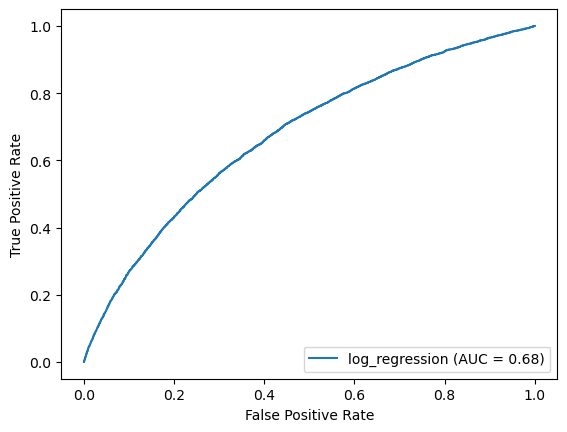

In [573]:
test_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau': True
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

train('log_regression', config=test_config, dev_mode=False)

# Experiments
## Dummy classifier

Set the baseline with the Dummy Classifier

Training the model
Loading application_train ...


2023/11/15 10:24:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99efc56521ce44b68edbd0288454132d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/15 10:24:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/15 10:24:16 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/15 10:24:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow Data

-------------------------
ROC AUC: 0.5
Accuracy: 0.92
Fbeta score(b=10): 0.0
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 8.94 seconds 



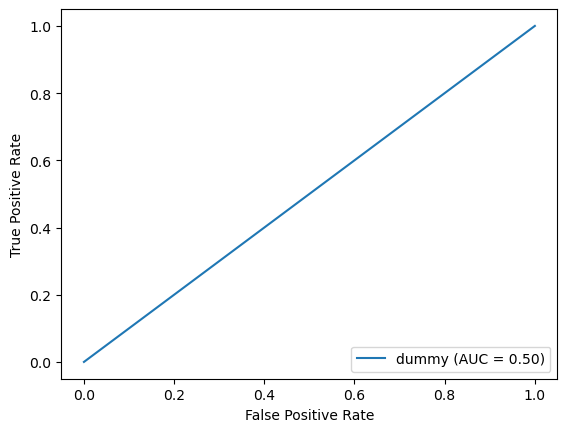

In [515]:
train('dummy', config={'strategy': 'prior'}, dev_mode=False)

TODO: explanation

## Logistic Regression

We will start with the most simple configuration.

In [576]:
# Set the experiment
mlflow.set_experiment("Logistic Regression")

# Track models automatically
mlflow.sklearn.autolog()

In [516]:
config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

In [535]:
# test on sample
config['balancing']['should_oversample'] = True
config['balancing']['with_categorical'] = True

train('log_regression', config, dev_mode=True)

2023/11/15 11:00:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/15 11:00:09 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/15 11:00:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Training the model
Loading application_train ...
Loading Done.
Train shape: (800, 121)
Valid shape: (800,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   0.0s
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.0s


2023/11/15 11:00:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///Users/natche/Jupiter/Project%207/mlruns/972159027913578879/6a92fa47e6664e7490737cc069bfcc52/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/11/15 11:00:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 6a92fa47e6664e7490737cc069bfcc52. Failed operations: [MlflowException("The run 6a92fa47e6664e7490737cc069bfcc52 must be in \'active\' lifecycle_stage."), MlflowException("The run 6a92fa47e6664e7490737cc069bfcc52 must be in \'active\' lifecycle_stage.")]')]
2023/11/15 11:00:10 WARNING mlflow.utils.autologging_utils: MLflow autologging en

[Pipeline] .......... (step 5 of 7) Processing smote_nc, total=   1.3s
[Pipeline] ........... (step 6 of 7) Processing encoder, total=   0.0s


2023/11/15 11:00:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/15 11:00:12 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have 

[Pipeline] ........ (step 7 of 7) Processing classifier, total=   1.5s
-------------------------
ROC AUC: 0.5


MlflowException: The run 6a92fa47e6664e7490737cc069bfcc52 must be in 'active' lifecycle_stage.

### Baseline

In [577]:
mlflow.end_run()

MlflowException: The run 4989d39c3c264b8db317dbc6d4353412 must be in 'active' lifecycle_stage.

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/15 11:01:02 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', ApplicationEncoder())],
         verbose=True)), ('class...`
2023/11/15 11:01:04 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


[Pipeline] ........... (step 1 of 5) Processing cleaner, total=   0.3s
[Pipeline] . (step 2 of 5) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 5) Processing imputer, total=   2.5s
[Pipeline] ............ (step 4 of 5) Processing scalar, total=   0.3s
[Pipeline] ........... (step 5 of 5) Processing encoder, total=   1.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.8s


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/15 11:01:24 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/15 11:01:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a

-------------------------
ROC AUC: 0.5
Accuracy: 0.92
Fbeta score(b=10): 0.0
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 29.06 seconds 



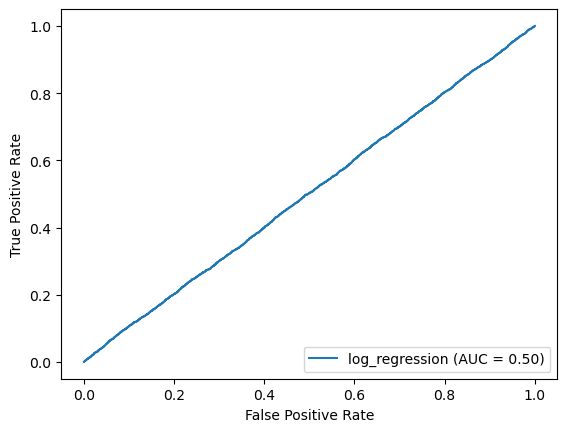

In [538]:
base_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

with mlflow.start_run(run_name = 'log_regression_baseline'):
    train('log_regression', config=base_config, dev_mode=False)

mlflow.end_run()

### With SMOTE

In [539]:
smote_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.3s
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   2.5s
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.2s
[Pipeline] ........... (step 5 of 7) Processing encoder, total=   1.1s


2023/11/15 11:02:41 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/15 11:02:41 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/15 11:02:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ............. (step 6 of 7) Processing smote, total=   4.0s


2023/11/15 11:02:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/15 11:02:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 7 of 7) Processing classifier, total=  15.9s


2023/11/15 11:03:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/15 11:03:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

-------------------------
ROC AUC: 0.64
Accuracy: 0.68
Fbeta score(b=10): 0.58
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56619
           1       0.14      0.60      0.23      4884

    accuracy                           0.68     61503
   macro avg       0.55      0.64      0.51     61503
weighted avg       0.89      0.68      0.75     61503

-------------------------
execution time: 30.95 seconds 



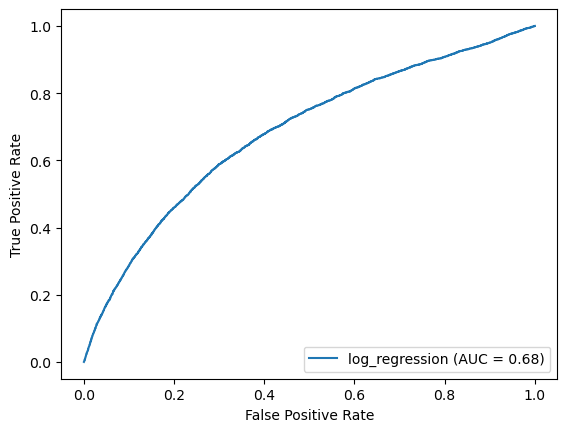

In [540]:
with mlflow.start_run(run_name = 'log_regression_base_smote'):
    train('log_regression', config=smote_config, dev_mode=False)

mlflow.end_run()

### With SMOTENC

In [541]:
smotenc_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42
    }
}

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 7) Processing cleaner, total=   0.3s
[Pipeline] . (step 2 of 7) Processing feature_extractor, total=   0.0s
[Pipeline] ........... (step 3 of 7) Processing imputer, total=   2.4s
[Pipeline] ............ (step 4 of 7) Processing scalar, total=   0.2s


2023/11/15 11:04:02 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/15 11:04:02 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/15 11:04:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] .......... (step 5 of 7) Processing smote_nc, total= 4.4min
[Pipeline] ........... (step 6 of 7) Processing encoder, total=   2.4s


2023/11/15 11:08:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/15 11:08:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 7 of 7) Processing classifier, total=  16.3s


2023/11/15 11:08:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/15 11:08:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

-------------------------
ROC AUC: 0.63
Accuracy: 0.76
Fbeta score(b=10): 0.47
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56619
           1       0.16      0.48      0.24      4884

    accuracy                           0.76     61503
   macro avg       0.55      0.63      0.55     61503
weighted avg       0.88      0.76      0.81     61503

-------------------------
execution time: 294.35 seconds 



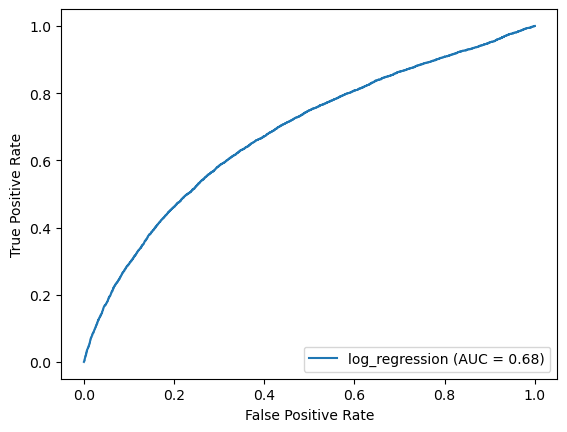

In [542]:
with mlflow.start_run(run_name = 'log_regression_base_smotenc'):
    train('log_regression', config=smotenc_config, dev_mode=False)

mlflow.end_run()

### With bureau and balance

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 8) Processing cleaner, total=   0.3s
[Pipeline] . (step 2 of 8) Processing feature_extractor, total=   0.0s
shape before  (246008, 128)
new shape after merge (246008, 244)
[Pipeline]  (step 3 of 8) Processing merge_bureau_and_balance, total=   0.2s
[Pipeline] ........... (step 4 of 8) Processing imputer, total=   4.4s
[Pipeline] ............ (step 5 of 8) Processing scalar, total=   0.4s
[Pipeline] ........... (step 6 of 8) Processing encoder, total=   1.3s


2023/11/16 17:04:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/16 17:04:09 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/16 17:04:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ............. (step 7 of 8) Processing smote, total=   5.1s


2023/11/16 17:04:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/16 17:04:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda

[Pipeline] ........ (step 8 of 8) Processing classifier, total=  20.3s
shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/16 17:04:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/16 17:04:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
ROC AUC: 0.63
Accuracy: 0.69
Fbeta score(b=10): 0.55
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.80     56619
           1       0.14      0.56      0.22      4884

    accuracy                           0.69     61503
   macro avg       0.54      0.63      0.51     61503
weighted avg       0.88      0.69      0.76     61503

-------------------------
execution time: 51.41 seconds 



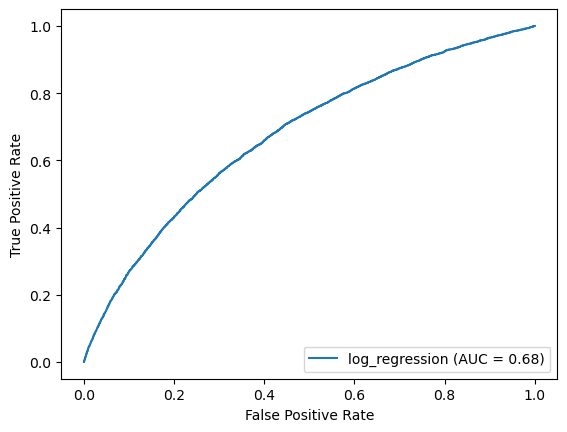

In [578]:
with_bureau_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau': True
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42
    }
}
with mlflow.start_run(run_name = 'log_regression_with_bureau'):
    train('log_regression', config=with_bureau_config, dev_mode=False)
mlflow.end_run()